<a href="https://colab.research.google.com/github/mohankgaddam/Model_Deployment/blob/master/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this Notebook, I built a text classification model using tensorflow to predict the sentiment of reviews for furniture products. I used Amazon Furniture product reviews to train the model.

# 1) Initialization






## **1.1) Examine the GPU Configuration**

In [1]:
!nvidia-smi

Sun Apr 19 22:46:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## 1.2) Import required packages

In [2]:
import datetime
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow_datasets as tfds

print(tf.__version__)
tf.config.experimental.list_physical_devices()

2.2.0-rc3


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2) Pull Source Data

I am using the amazon reviews dataset available in tensorflow for sentiment analysis. Specifically, I am considering only the reviews corresponding to Amazon Furniture products in US Marketplace.

More information about these datasets can be found at:

https://www.tensorflow.org/datasets/catalog/amazon_us_reviews
https://www.tensorflow.org/datasets/catalog/amazon_us_reviews#amazon_us_reviewsfurniture_v1_00

In [3]:
ds, info = tfds.load('amazon_us_reviews/Furniture_v1_00', with_info=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/amazon_us_reviews/Furniture_v1_00/0.1.0.incompleteDCSDSX/amazon_us_reviews-train.tfrecord


ERROR:absl:Statistics generation doesn't work for nested structures yet



Dataset amazon_us_reviews downloaded and prepared to /root/tensorflow_datasets/amazon_us_reviews/Furniture_v1_00/0.1.0. Subsequent calls will reuse this data.


In [0]:
train_ds = ds["train"].take(300000)

# 3) Data Preparation for Training

In [0]:
BUFFER_SIZE = 50000
BATCH_SIZE = 128

**Shuffle the train data to make sure the data is randomized**

In [0]:
train_ds = train_ds.shuffle(BUFFER_SIZE, reshuffle_each_iteration=False)

**Lets look at the first 5 rows of the train dataset**

In [7]:
for review in train_ds.take(5):
  print(review)

{'data': {'customer_id': <tf.Tensor: shape=(), dtype=string, numpy=b'16021291'>, 'helpful_votes': <tf.Tensor: shape=(), dtype=int32, numpy=4>, 'marketplace': <tf.Tensor: shape=(), dtype=string, numpy=b'US'>, 'product_category': <tf.Tensor: shape=(), dtype=string, numpy=b'Furniture'>, 'product_id': <tf.Tensor: shape=(), dtype=string, numpy=b'B009IWJU66'>, 'product_parent': <tf.Tensor: shape=(), dtype=string, numpy=b'860711835'>, 'product_title': <tf.Tensor: shape=(), dtype=string, numpy=b"Big Joe Fuf 6' Media Lounger, Zebra Twill">, 'review_body': <tf.Tensor: shape=(), dtype=string, numpy=b"I ordered this for my dorm and I absolutely love it! It's so comfy and fun to lay on and just Do my homework... Thank you so much do the great product!!!">, 'review_date': <tf.Tensor: shape=(), dtype=string, numpy=b'2013-02-05'>, 'review_headline': <tf.Tensor: shape=(), dtype=string, numpy=b'Love it!'>, 'review_id': <tf.Tensor: shape=(), dtype=string, numpy=b'R3RGNCINAE5WOY'>, 'star_rating': <tf.Tens

**Tokenize the data and build the vocabulary set**

In [8]:
tokenizer = tfds.features.text.Tokenizer()

#Initialize a vocabulary as a set data structure to ensure there are no duplicates in the vocabulary words
vocab_set = set()  

#Iterate through each review in the train data and 
#update the vocabulary set with the unique words in the review text
for _, review in train_ds.enumerate():
  review_data = review['data']
  review_tokens = tokenizer.tokenize(review_data.get('review_body').numpy())
  vocab_set.update(review_tokens)

vocab_size = len(vocab_set)
print("vocabulory size is: ", vocab_size) 

#Encode the vocabulary words into numbers 
encoder = tfds.features.text.TokenTextEncoder(vocab_set)


vocabulory size is:  87988


**Get the encoded values and the corresponding label (0 or 1) from all the reviews in the train data**

In [0]:
def encode_and_label(text_tensor, rating_tensor):
  '''
  Input: text, rating tensors

  Output: encoded text and label
  '''
  encoded_text = encoder.encode(text_tensor.numpy())
  label = tf.where(rating_tensor > 3, 1, 0)

  return encoded_text, label

In [0]:
def encode_map_fn(tensor):
  '''
  This function gets the review text and rating from the tensor object,
  and returns the encoded review text along with the binary label (1 for positive review, 0 for negative review)
  
  Input : A review tensor
  
  Output: encoded review text and the label  
  '''

  #Get review text and rating  
  review_text = tensor['data'].get('review_body')
  review_rating = tensor['data'].get('star_rating')

  #Get the encoded text and the corresponding label
  encoded_text, label = tf.py_function(encode_and_label, 
                                       inp=[review_text, review_rating], 
                                       Tout=(tf.int64, tf.int32))
  

  return encoded_text, label

In [0]:
train_encoded_ds = train_ds.map(encode_map_fn)

In [12]:
#Let`s look at a few sample records of encoded train data.
for text,label in train_encoded_ds.take(3):
  print(text)
  print(label)

tf.Tensor(
[32719 10493  4256 46498 56722 14171 23947 32719 77178 85795  3950 65271
  9021 79736 57797 23947 31445 32192 64207   398 23947  6617 42753 56722
 60937 32001 38591 79736  3287 14781 33735 34168  6969], shape=(33,), dtype=int64)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor([81737 15931], shape=(2,), dtype=int64)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor([12146 32192 10910 23947  1903 42367], shape=(6,), dtype=int64)
tf.Tensor(1, shape=(), dtype=int32)


**Create a Callback to store the best model**

In [0]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = '/tmp/sentiment_analysis.hdf5', verbose=1, save_best_only=True)

#4) Train & Validation data Split

In [0]:
VALIDATION_DATA_SIZE = 15000

train_data = train_encoded_ds.skip(VALIDATION_DATA_SIZE).shuffle(BUFFER_SIZE)           #Skip validation rows, shuffle and assign the remaining rows to train data
train_data = train_data.padded_batch(BATCH_SIZE, padded_shapes=([None], []))            #Pad for each batch

validation_data = train_encoded_ds.take(VALIDATION_DATA_SIZE)
validation_data = validation_data.padded_batch(BATCH_SIZE, padded_shapes=([None], []))

vocab_size = vocab_size + 1

#5) Model Training

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [0]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
history = model.fit(train_data, epochs=5, validation_data = validation_data, callbacks=[checkpointer])

Epoch 1/5
2227/2227 [==============================] - ETA: 0s - loss: 0.2592 - accuracy: 0.8899
Epoch 00001: val_loss improved from inf to 0.18845, saving model to /tmp/sentiment_analysis.hdf5
2227/2227 [==============================] - 792s 355ms/step - loss: 0.2592 - accuracy: 0.8899 - val_loss: 0.1885 - val_accuracy: 0.9211
Epoch 2/5
2227/2227 [==============================] - ETA: 0s - loss: 0.1817 - accuracy: 0.9269
Epoch 00002: val_loss did not improve from 0.18845
2227/2227 [==============================] - 791s 355ms/step - loss: 0.1817 - accuracy: 0.9269 - val_loss: 0.1899 - val_accuracy: 0.9186
Epoch 3/5
2227/2227 [==============================] - ETA: 0s - loss: 0.1534 - accuracy: 0.9393
Epoch 00003: val_loss did not improve from 0.18845
2227/2227 [==============================] - 792s 356ms/step - loss: 0.1534 - accuracy: 0.9393 - val_loss: 0.1943 - val_accuracy: 0.9226
Epoch 4/5
2227/2227 [==============================] - ETA: 0s - loss: 0.1299 - accuracy: 0.9497
Ep

**Save the vocabulory and model files for deployment**

In [0]:
encoder.save_to_file('/tmp/data_vocabulory')
model.save('/tmp/final_model.hdf5')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         11262592  
_________________________________________________________________
bidirectional (Bidirectional (None, None, 256)         263168    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 11,694,273
Trainable params: 11,694,273
Non-trainable params: 0
____________________________________________

**Helper Function to plot graphs**

In [0]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend(['train_'+metric, 'val_'+metric])
  plt.show()

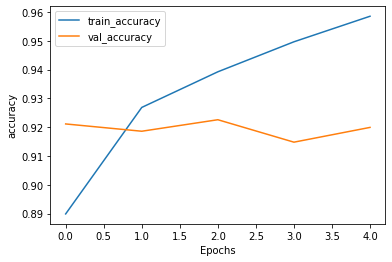

In [23]:
plot_graphs(history, 'accuracy')

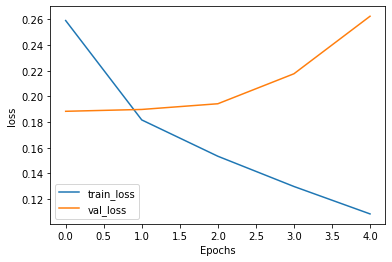

In [24]:
plot_graphs(history, 'loss')